In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class CoolingPlateVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(CoolingPlateVAE, self).__init__()

        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        # Latent space
        self.fc_mu = nn.Linear(256 * 64 * 64, latent_dim)
        self.fc_logvar = nn.Linear(256 * 64 * 64, latent_dim)
        self.decoder_input = nn.Linear(latent_dim, 256 * 64 * 64)

        # Decoder (Fixed output size to 1024×1024)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 64 → 128
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 128 → 256
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 256 → 512
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),    # 512 → 1024
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1),     # Keep 1024×1024
            nn.Sigmoid()  # Output range [0,1]
        )

    def reparameterize(self, mu, logvar):
        std   nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 128 → 256
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 256 → 512
            nn.ReLU(),
           = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)

        x = self.decoder_input(z)
        x = x.view(x.size(0), 256, 64, 64)  # Reshape for decoder
        x = self.decoder(x)

        return x, mu, logvar


In [16]:
class CoolingPlateDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image

# Define Transformations for 1024×1024 images
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),  # Resize to 1024×1024
    transforms.ToTensor()  # Normalize to [0,1]
])

# Load dataset
image_folder = "/content/dataset"
dataset = CoolingPlateDataset(image_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


In [17]:
# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 128
model = CoolingPlateVAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

def vae_loss(recon_x, x, mu, logvar):
    """VAE Loss: Reconstruction + KL Divergence"""
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + 0.001 * kl_div  # Adjust KL weight as needed

# Training Loop
num_epochs = 50
for epoch in range(num_epochs):
    total_loss = 0
    for images in dataloader:
        images = images.to(device)

        optimizer.zero_grad()
        reconstructed, mu, logvar = model(images)  # Forward pass
        loss = vae_loss(reconstructed, images, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}")

# Save trained model
torch.save(model.state_dict(), "vae_cooling_plate_1024.pth")
print("Training Complete!")


Epoch [1/50], Loss: 0.2489
Epoch [2/50], Loss: 0.1979
Epoch [3/50], Loss: 0.1450
Epoch [4/50], Loss: 0.1397
Epoch [5/50], Loss: 0.1372
Epoch [6/50], Loss: 0.1351
Epoch [7/50], Loss: 0.1275
Epoch [8/50], Loss: 0.1263
Epoch [9/50], Loss: 0.1160
Epoch [10/50], Loss: 0.1113
Epoch [11/50], Loss: 0.1048
Epoch [12/50], Loss: 0.0968
Epoch [13/50], Loss: 0.0854
Epoch [14/50], Loss: 0.0719
Epoch [15/50], Loss: 0.0570
Epoch [16/50], Loss: 0.0440
Epoch [17/50], Loss: 0.0351
Epoch [18/50], Loss: 0.0302
Epoch [19/50], Loss: 0.0266
Epoch [20/50], Loss: 0.0240
Epoch [21/50], Loss: 0.0220
Epoch [22/50], Loss: 0.0208
Epoch [23/50], Loss: 0.0198
Epoch [24/50], Loss: 0.0181
Epoch [25/50], Loss: 0.0177
Epoch [26/50], Loss: 0.0163
Epoch [27/50], Loss: 0.0155
Epoch [28/50], Loss: 0.0143
Epoch [29/50], Loss: 0.0137
Epoch [30/50], Loss: 0.0129
Epoch [31/50], Loss: 0.0122
Epoch [32/50], Loss: 0.0117
Epoch [33/50], Loss: 0.0110
Epoch [34/50], Loss: 0.0100
Epoch [35/50], Loss: 0.0095
Epoch [36/50], Loss: 0.0088
E

In [18]:
sample_input = torch.randn(1, 3, 1024, 1024).to(device)
output, _, _ = model(sample_input)
print("Output size:", output.shape)  # Should be [1, 3, 1024, 1024]


Output size: torch.Size([1, 3, 1024, 1024])


<ipython-input-19-62e6611e96c0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("vae_cooling_plate_1024.pth"))


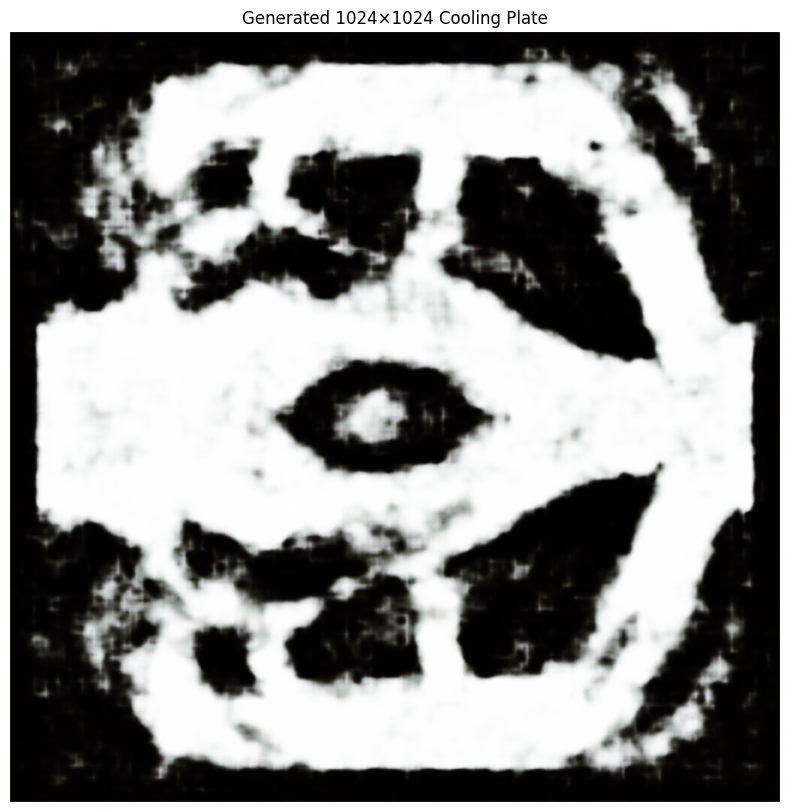

In [19]:
# Load trained model
model.load_state_dict(torch.load("vae_cooling_plate_1024.pth"))
model.eval()

# Generate new cooling plate
z = torch.randn(1, latent_dim).to(device)  # Sample a random latent vector
generated = model.decoder(model.decoder_input(z).view(1, 256, 64, 64))  # Decode to image
generated = generated.cpu().detach().squeeze(0)  # Convert tensor to numpy

# Convert to image and save
generated_image = transforms.ToPILImage()(generated)
generated_image.save("generated_cooling_plate_1024.png")

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(generated.permute(1, 2, 0))
plt.axis("off")
plt.title("Generated 1024×1024 Cooling Plate")
plt.show()
